In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import SQL_queries as q

# Exploratory Data Analysis - Pittsburgh Penguins Playoff Data From 2016 and 2017
--------
### To begin the EDA process, I use SQL queries to build DataFrames to include:

* general information about each game, play, event, and event locations
* skater stats
* team stats
* shift information
### [Check out the queries for yourself](SQL_queries.py)
----



In [2]:
conn = sqlite3.connect('NHL_data.db')

In [3]:
pens_2016_playoff_df = pd.read_sql_query(q.playoff_2016_data_query, conn)
pens_2016_playoff_df.head()

,Unnamed: 0,play_id,game_id,team_id_for,team_id_against,event,secondaryType,x,y,period,...,periodTimeRemaining,dateTime,goals_away,goals_home,play_id,game_id,player_id,playerType,firstName,lastName
0,3165356,2015030141_4,2015030141,5.0,3.0,Faceoff,None,0.0,0.0,1,...,1200.0,2016-04-14 01:10:15,0,0,2015030141_4,2015030141,8471675,Winner,Sidney,Crosby
1,3165356,2015030141_4,2015030141,5.0,3.0,Faceoff,None,0.0,0.0,1,...,1200.0,2016-04-14 01:10:15,0,0,2015030141_4,2015030141,8474613,Loser,Derek,Stepan
2,3165358,2015030141_6,2015030141,3.0,5.0,Faceoff,None,-69.0,22.0,1,...,1193.0,2016-04-14 01:10:52,0,0,2015030141_6,2015030141,8471675,Loser,Sidney,Crosby
3,3165358,2015030141_6,2015030141,3.0,5.0,Faceoff,None,-69.0,22.0,1,...,1193.0,2016-04-14 01:10:52,0,0,2015030141_6,2015030141,8474613,Winner,Derek,Stepan
4,3165359,2015030141_7,2015030141,3.0,5.0,Hit,None,-5.0,-40.0,1,...,1185.0,2016-04-14 01:11:17,0,0,2015030141_7,2015030141,8470630,Hitter,Kevin,Klein


In [4]:
pens_2017_playoff_df = pd.read_sql_query(q.playoff_2017_data_query, conn)
pens_2017_playoff_df.head()

,Unnamed: 0,play_id,game_id,team_id_for,team_id_against,event,secondaryType,x,y,period,...,periodTimeRemaining,dateTime,goals_away,goals_home,play_id,game_id,player_id,playerType,firstName,lastName
0,3211410,2016030141_4,2016030141,29.0,5.0,Faceoff,None,0.0,0.0,1,...,1200.0,2017-04-13 00:40:08,0,0,2016030141_4,2016030141,8471273,Winner,Brandon,Dubinsky
1,3211410,2016030141_4,2016030141,29.0,5.0,Faceoff,None,0.0,0.0,1,...,1200.0,2017-04-13 00:40:08,0,0,2016030141_4,2016030141,8471675,Loser,Sidney,Crosby
2,3211411,2016030141_5,2016030141,29.0,5.0,Hit,None,3.0,39.0,1,...,1182.0,2017-04-13 00:40:40,0,0,2016030141_5,2016030141,8476432,Hitter,Boone,Jenner
3,3211411,2016030141_5,2016030141,29.0,5.0,Hit,None,3.0,39.0,1,...,1182.0,2017-04-13 00:40:40,0,0,2016030141_5,2016030141,8477404,Hittee,Jake,Guentzel
4,3211412,2016030141_6,2016030141,29.0,5.0,Hit,None,-91.0,-36.0,1,...,1178.0,2017-04-13 00:40:44,0,0,2016030141_6,2016030141,8471273,Hitter,Brandon,Dubinsky


### The query was quick and easy, but seems to have given some repetitive data. To confirm, I checked the columns:

In [5]:
pens_2016_playoff_df.columns

Index(['Unnamed: 0', 'play_id', 'game_id', 'team_id_for', 'team_id_against',
       'event', 'secondaryType', 'x', 'y', 'period', 'periodType',
       'periodTime', 'periodTimeRemaining', 'dateTime', 'goals_away',
       'goals_home', 'play_id', 'game_id', 'player_id', 'playerType',
       'firstName', 'lastName'],
      dtype='object')

### As expected, some columns are the same.
Below I drop any duplicated columns, as well as any additional columns that are unnecessary at this time.

In [6]:
playoff_dfs = [pens_2016_playoff_df, pens_2017_playoff_df]

In [7]:
fixed_playoff_dfs = []
for df in playoff_dfs:
    df = df.iloc[:,~df.columns.duplicated()]
    df = df.drop(['Unnamed: 0','player_id'], axis=1)
    fixed_playoff_dfs.append(df)


In [8]:
fixed_playoff_dfs

[              play_id     game_id  team_id_for  team_id_against         event  \
 0        2015030141_4  2015030141          5.0              3.0       Faceoff   
 1        2015030141_4  2015030141          5.0              3.0       Faceoff   
 2        2015030141_6  2015030141          3.0              5.0       Faceoff   
 3        2015030141_6  2015030141          3.0              5.0       Faceoff   
 4        2015030141_7  2015030141          3.0              5.0           Hit   
 ...               ...         ...          ...              ...           ...   
 13174  2015030416_369  2015030416          5.0             28.0       Penalty   
 13175  2015030416_370  2015030416          5.0             28.0       Faceoff   
 13176  2015030416_370  2015030416          5.0             28.0       Faceoff   
 13177  2015030416_371  2015030416          5.0             28.0  Blocked Shot   
 13178  2015030416_371  2015030416          5.0             28.0  Blocked Shot   
 
       seconda

In [9]:
pens_2016_playoff_df = fixed_playoff_dfs[0]
pens_2017_playoff_df = fixed_playoff_dfs[1]

check to verify changes:

In [10]:
pens_2016_playoff_df.columns

Index(['play_id', 'game_id', 'team_id_for', 'team_id_against', 'event',
       'secondaryType', 'x', 'y', 'period', 'periodType', 'periodTime',
       'periodTimeRemaining', 'dateTime', 'goals_away', 'goals_home',
       'playerType', 'firstName', 'lastName'],
      dtype='object')

### To explore, let's take a closer look at event, secondaryType, and periodType:

In [11]:
pens_2016_playoff_df.event.unique()

array(['Faceoff', 'Hit', 'Blocked Shot', 'Shot', 'Missed Shot',
       'Giveaway', 'Penalty', 'Takeaway', 'Goal'], dtype=object)

In [12]:
pens_2016_playoff_df.secondaryType.unique()

array([None, 'Snap Shot', 'Wrist Shot', 'Slap Shot', 'Wrap-around',
       'Hooking', 'Tip-In', 'Illegal check to head',
       'Unsportsmanlike conduct', 'Interference', 'Backhand', 'Holding',
       'Tripping', 'Hi stick - double minor', 'Roughing',
       'Interference - Goalkeeper', 'Slashing', 'Cross checking',
       'Fighting', 'Boarding', 'Holding the stick', 'Hi-sticking',
       'Embellishment', 'Too many men on the ice',
       'Delaying Game - Puck over glass', 'Elbowing', 'Misconduct',
       'Deflected'], dtype=object)

In [13]:
pens_2016_playoff_df.periodType.unique()

array(['REGULAR', 'OVERTIME'], dtype=object)

### Next, check for null values in both DataFrames:

In [14]:
pens_2016_playoff_df.info()
pens_2017_playoff_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13179 entries, 0 to 13178
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   play_id              13179 non-null  object 
 1   game_id              13179 non-null  int64  
 2   team_id_for          13179 non-null  float64
 3   team_id_against      13179 non-null  float64
 4   event                13179 non-null  object 
 5   secondaryType        3586 non-null   object 
 6   x                    13163 non-null  float64
 7   y                    13165 non-null  float64
 8   period               13179 non-null  int64  
 9   periodType           13179 non-null  object 
 10  periodTime           13179 non-null  int64  
 11  periodTimeRemaining  13179 non-null  float64
 12  dateTime             13179 non-null  object 
 13  goals_away           13179 non-null  int64  
 14  goals_home           13179 non-null  int64  
 15  playerType           13179 non-null 

Secondary type is the only column that contains null values. What percent are null? Is this column worth keeping?

In [15]:
secondary_type_percent_null_1 = (pens_2016_playoff_df['secondaryType'].isnull().sum())/13179*100
secondary_type_percent_null_2 = (pens_2017_playoff_df['secondaryType'].isnull().sum())/11559*100

print(f'2016 Secondary Type Null Percent :{secondary_type_percent_null_1:.2f}%')
print(f'2017 Secondary Type Null Percent :{secondary_type_percent_null_2:.2f}%')


2016 Secondary Type Null Percent :72.79%
2017 Secondary Type Null Percent :71.62%


Looking in on what events have secondary types:

In [16]:
pens_2016_playoff_df[pens_2016_playoff_df['event']=='Penalty']

,play_id,game_id,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,playerType,firstName,lastName
64,2015030141_45,2015030141,3.0,5.0,Penalty,Hooking,-69.0,-37.0,1,REGULAR,319,881.0,2016-04-14 01:19:52,0,0,PenaltyOn,Viktor,Stalberg
65,2015030141_45,2015030141,3.0,5.0,Penalty,Hooking,-69.0,-37.0,1,REGULAR,319,881.0,2016-04-14 01:19:52,0,0,DrewBy,Justin,Schultz
113,2015030141_75,2015030141,3.0,5.0,Penalty,Illegal check to head,-97.0,28.0,1,REGULAR,647,553.0,2016-04-14 01:33:50,0,0,PenaltyOn,Viktor,Stalberg
114,2015030141_75,2015030141,3.0,5.0,Penalty,Illegal check to head,-97.0,28.0,1,REGULAR,647,553.0,2016-04-14 01:33:50,0,0,DrewBy,Ian,Cole
125,2015030141_84,2015030141,5.0,3.0,Penalty,Unsportsmanlike conduct,NaN,NaN,1,REGULAR,779,421.0,2016-04-14 01:37:32,0,0,DrewBy,Henrik,Lundqvist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13080,2015030416_303,2015030416,5.0,28.0,Penalty,Hooking,-29.0,-33.0,3,REGULAR,326,874.0,2016-06-13 03:18:14,2,1,PenaltyOn,Conor,Sheary
13118,2015030416_329,2015030416,28.0,5.0,Penalty,Slashing,-35.0,11.0,3,REGULAR,662,538.0,2016-06-13 03:25:48,2,1,PenaltyOn,Brent,Burns
13119,2015030416_329,2015030416,28.0,5.0,Penalty,Slashing,-35.0,11.0,3,REGULAR,662,538.0,2016-06-13 03:25:48,2,1,DrewBy,Phil,Kessel
13173,2015030416_369,2015030416,5.0,28.0,Penalty,Hi-sticking,32.0,4.0,3,REGULAR,1190,10.0,2016-06-13 03:46:00,3,1,PenaltyOn,Eric,Fehr


In [17]:
pens_2016_playoff_df[pens_2016_playoff_df['event']=='Shot']

,play_id,game_id,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,playerType,firstName,lastName
12,2015030141_11,2015030141,5.0,3.0,Shot,Snap Shot,45.0,-19.0,1,REGULAR,115,1085.0,2016-04-14 01:12:47,0,0,Goalie,Henrik,Lundqvist
13,2015030141_11,2015030141,5.0,3.0,Shot,Snap Shot,45.0,-19.0,1,REGULAR,115,1085.0,2016-04-14 01:12:47,0,0,Shooter,Phil,Kessel
25,2015030141_20,2015030141,3.0,5.0,Shot,Wrist Shot,-63.0,-6.0,1,REGULAR,165,1035.0,2016-04-14 01:14:16,0,0,Goalie,Jeff,Zatkoff
26,2015030141_20,2015030141,3.0,5.0,Shot,Wrist Shot,-63.0,-6.0,1,REGULAR,165,1035.0,2016-04-14 01:14:16,0,0,Shooter,J.T.,Miller
33,2015030141_24,2015030141,3.0,5.0,Shot,Slap Shot,-47.0,35.0,1,REGULAR,213,987.0,2016-04-14 01:15:10,0,0,Shooter,Kevin,Klein
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13132,2015030416_339,2015030416,5.0,28.0,Shot,Slap Shot,-81.0,-5.0,3,REGULAR,858,342.0,2016-06-13 03:34:03,2,1,Goalie,Martin,Jones
13142,2015030416_346,2015030416,5.0,28.0,Shot,Wrist Shot,-76.0,17.0,3,REGULAR,957,243.0,2016-06-13 03:35:44,2,1,Shooter,Carl,Hagelin
13143,2015030416_346,2015030416,5.0,28.0,Shot,Wrist Shot,-76.0,17.0,3,REGULAR,957,243.0,2016-06-13 03:35:44,2,1,Goalie,Martin,Jones
13164,2015030416_363,2015030416,28.0,5.0,Shot,Wrist Shot,57.0,-25.0,3,REGULAR,1154,46.0,2016-06-13 03:43:58,3,1,Shooter,Joonas,Donskoi


### After seeing that 72% & 73% of secondaryType rows are NULL, I've decided to drop the columns. 
When it comes to penalties, for this project I'll be looking at the penalty differentials, for which these types listed won't matter. Additionally, I'll be making a DataFrame specifically for shots, in which I can use the secondary type for this event. For now, event will suffice.

In [24]:
pens_2016_playoff_df = pens_2016_playoff_df.drop('secondaryType',axis=1)
pens_2017_playoff_df = pens_2017_playoff_df.drop('secondaryType', axis=1)

### Next step : Make things easier to discern.
To replace the columns team_id_for and team_id_against with abbreviations instead of numbers, I first pulled the data using a SQL query from the database, created a DataFrame, and then transformed it to a dictionary. Using this dictionary, the team_id numbers are replaced with easily identifiable team info.

In [25]:
team_ids_df = pd.read_sql_query(q.get_abb_query, conn)
abb_dict = pd.Series(team_ids_df.abbreviation.values,index=team_ids_df.team_id).to_dict()
abb_dict

{1: 'NJD',
 4: 'PHI',
 26: 'LAK',
 14: 'TBL',
 6: 'BOS',
 3: 'NYR',
 5: 'PIT',
 17: 'DET',
 28: 'SJS',
 18: 'NSH',
 23: 'VAN',
 16: 'CHI',
 9: 'OTT',
 8: 'MTL',
 30: 'MIN',
 15: 'WSH',
 19: 'STL',
 24: 'ANA',
 27: 'PHX',
 2: 'NYI',
 10: 'TOR',
 13: 'FLA',
 7: 'BUF',
 20: 'CGY',
 21: 'COL',
 25: 'DAL',
 29: 'CBJ',
 52: 'WPG',
 22: 'EDM',
 54: 'VGK',
 12: 'CAR',
 53: 'ARI',
 11: 'ATL'}

In [26]:
#reset the df lists once more
dfs = [pens_2016_playoff_df,pens_2017_playoff_df]
fixed_playoff_dfs = []
#replace and rename for each
for df in dfs:
    df = df.replace({'team_id_for':abb_dict})
    df = df.replace({'team_id_against':abb_dict})
    df = df.rename(columns={'team_id_for':'team_for', 'team_id_against':'team_against'})
    fixed_playoff_dfs.append(df)
#reassign to original df names
pens_2016_playoff_df = fixed_playoff_dfs[0]
pens_2017_playoff_df = fixed_playoff_dfs[1]

In [27]:
pens_2016_playoff_df.head()

,play_id,game_id,team_for,team_against,event,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,playerType,firstName,lastName
0,2015030141_4,2015030141,PIT,NYR,Faceoff,0.0,0.0,1,REGULAR,0,1200.0,2016-04-14 01:10:15,0,0,Winner,Sidney,Crosby
1,2015030141_4,2015030141,PIT,NYR,Faceoff,0.0,0.0,1,REGULAR,0,1200.0,2016-04-14 01:10:15,0,0,Loser,Derek,Stepan
2,2015030141_6,2015030141,NYR,PIT,Faceoff,-69.0,22.0,1,REGULAR,7,1193.0,2016-04-14 01:10:52,0,0,Loser,Sidney,Crosby
3,2015030141_6,2015030141,NYR,PIT,Faceoff,-69.0,22.0,1,REGULAR,7,1193.0,2016-04-14 01:10:52,0,0,Winner,Derek,Stepan
4,2015030141_7,2015030141,NYR,PIT,Hit,-5.0,-40.0,1,REGULAR,15,1185.0,2016-04-14 01:11:17,0,0,Hitter,Kevin,Klein


### Take a closer look at game_id
I'll want to do game by game analysis for players. I need to be able to:
* group by game_id
* groupy by opposing team (the team playing against the Pittsburgh Penguins)
* consider how many games are played for each playoff round

In [28]:
games_teams_2016 = pens_2016_playoff_df.groupby('game_id').team_for.unique().reset_index()
games_teams_2017 = pens_2017_playoff_df.groupby('game_id').team_for.unique().reset_index()

In [29]:
games_teams_2017

,game_id,team_for
0,2016030141,"[CBJ, PIT]"
1,2016030142,"[CBJ, PIT]"
2,2016030143,"[PIT, CBJ]"
3,2016030144,"[PIT, CBJ]"
4,2016030145,"[PIT, CBJ]"
5,2016030221,"[PIT, WSH]"
6,2016030222,"[WSH, PIT]"
7,2016030223,"[PIT, WSH]"
8,2016030224,"[WSH, PIT]"
9,2016030226,"[PIT, WSH]"


This is helpful, but it shows both teams, where I only need the opposing team. 

In [30]:
games_teams_2016['opposing_team'] = games_teams_2016['team_for'].apply(
    lambda row: [val for val in row if val != 'PIT']
)
games_teams_2016.drop('team_for',axis=1, inplace=True)
games_teams_2016

,game_id,opposing_team
0,2015030141,[NYR]
1,2015030142,[NYR]
2,2015030143,[NYR]
3,2015030144,[NYR]
4,2015030145,[NYR]
5,2015030221,[WSH]
6,2015030222,[WSH]
7,2015030223,[WSH]
8,2015030224,[WSH]
9,2015030225,[WSH]


In [31]:
games_teams_2017['opposing_team'] = games_teams_2017['team_for'].apply(
   
    lambda row: [val for val in row if val != 'PIT']
)
games_teams_2017.drop('team_for',axis=1, inplace=True)

In [32]:
games_teams_2017

,game_id,opposing_team
0,2016030141,[CBJ]
1,2016030142,[CBJ]
2,2016030143,[CBJ]
3,2016030144,[CBJ]
4,2016030145,[CBJ]
5,2016030221,[WSH]
6,2016030222,[WSH]
7,2016030223,[WSH]
8,2016030224,[WSH]
9,2016030226,[WSH]


In [33]:
games_teams_2016.opposing_team.value_counts()

opposing_team
[TBL]    7
[WSH]    6
[SJS]    6
[NYR]    5
Name: count, dtype: int64

In [34]:
games_teams_2017.opposing_team.value_counts()

opposing_team
[WSH]    6
[OTT]    6
[CBJ]    5
[NSH]    5
Name: count, dtype: int64

Looking above, we can see how many games are played against each opposing team, for both years.

Next, I need lists of game_ids for each round of both playoff years.

In [35]:
#isolate the team name, since it has become a list instead of a string:
games_teams_2016['opposing_team'] = games_teams_2016['opposing_team'].str[0]

In [36]:
games_teams_2016

,game_id,opposing_team
0,2015030141,NYR
1,2015030142,NYR
2,2015030143,NYR
3,2015030144,NYR
4,2015030145,NYR
5,2015030221,WSH
6,2015030222,WSH
7,2015030223,WSH
8,2015030224,WSH
9,2015030225,WSH


In [37]:
#works well! do for 2017 also
games_teams_2017['opposing_team'] = games_teams_2017['opposing_team'].str[0]

In [38]:
games_teams_2016.groupby('opposing_team').game_id.unique()

opposing_team
NYR    [2015030141, 2015030142, 2015030143, 201503014...
SJS    [2015030411, 2015030412, 2015030413, 201503041...
TBL    [2015030311, 2015030312, 2015030313, 201503031...
WSH    [2015030221, 2015030222, 2015030223, 201503022...
Name: game_id, dtype: object

In [39]:
games_teams_2017.groupby('opposing_team').game_id.unique()

opposing_team
CBJ    [2016030141, 2016030142, 2016030143, 201603014...
NSH    [2016030411, 2016030412, 2016030413, 201603041...
OTT    [2016030311, 2016030312, 2016030314, 201603031...
WSH    [2016030221, 2016030222, 2016030223, 201603022...
Name: game_id, dtype: object

I want a list of only game_ids for each opposing team round:

In [40]:
#2016:
NYR_2016_games = list(games_teams_2016[games_teams_2016['opposing_team']=='NYR'].game_id)
SJS_2016_games = list(games_teams_2016[games_teams_2016['opposing_team']=='SJS'].game_id)
TBL_2016_games = list(games_teams_2016[games_teams_2016['opposing_team']=='TBL'].game_id)
WSH_2016_games = list(games_teams_2016[games_teams_2016['opposing_team']=='WSH'].game_id)
#2017:
CBJ_2017_games = list(games_teams_2017[games_teams_2017['opposing_team']=='CBJ'].game_id)
NSH_2017_games = list(games_teams_2017[games_teams_2017['opposing_team']=='NSH'].game_id)
OTT_2017_games = list(games_teams_2017[games_teams_2017['opposing_team']=='OTT'].game_id)
WSH_2017_games = list(games_teams_2017[games_teams_2017['opposing_team']=='WSH'].game_id)

### Next, I can choose to isolate information from the original large DataFrame, based on the game_id numbers

These were the round match-ups:

--------------


| Year   | 2016                  | 2017 |
|--------|-----------------------|-----|
| Round 1 | New York Rangers      | Columbus Blue Jackets |
| Round 2 | Washington Capitals   | Washington Capitals |
| Round 3 | Tampa Bay Lightning   | Ottowa Senators |
| Final | San Jose Sharks       | Nashville Predators |


In [41]:
#Breaking the data into separate rounds of the playoffs

#2016:
Round_1_2016 = pens_2016_playoff_df[pens_2016_playoff_df['game_id'].isin(NYR_2016_games)]
Round_2_2016 = pens_2016_playoff_df[pens_2016_playoff_df['game_id'].isin(WSH_2016_games)]
Round_3_2016 = pens_2016_playoff_df[pens_2016_playoff_df['game_id'].isin(TBL_2016_games)]
Round_4_2016 = pens_2016_playoff_df[pens_2016_playoff_df['game_id'].isin(SJS_2016_games)]

#2017:
Round_1_2017 = pens_2017_playoff_df[pens_2017_playoff_df['game_id'].isin(CBJ_2017_games)]
Round_2_2017 = pens_2017_playoff_df[pens_2017_playoff_df['game_id'].isin(WSH_2017_games)]
Round_3_2017 = pens_2017_playoff_df[pens_2017_playoff_df['game_id'].isin(OTT_2017_games)]
Round_4_2017 = pens_2017_playoff_df[pens_2017_playoff_df['game_id'].isin(NSH_2017_games)]


Take another look at what we have for this first DataFrame:

In [42]:
Round_1_2016

,play_id,game_id,team_for,team_against,event,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,playerType,firstName,lastName
0,2015030141_4,2015030141,PIT,NYR,Faceoff,0.0,0.0,1,REGULAR,0,1200.0,2016-04-14 01:10:15,0,0,Winner,Sidney,Crosby
1,2015030141_4,2015030141,PIT,NYR,Faceoff,0.0,0.0,1,REGULAR,0,1200.0,2016-04-14 01:10:15,0,0,Loser,Derek,Stepan
2,2015030141_6,2015030141,NYR,PIT,Faceoff,-69.0,22.0,1,REGULAR,7,1193.0,2016-04-14 01:10:52,0,0,Loser,Sidney,Crosby
3,2015030141_6,2015030141,NYR,PIT,Faceoff,-69.0,22.0,1,REGULAR,7,1193.0,2016-04-14 01:10:52,0,0,Winner,Derek,Stepan
4,2015030141_7,2015030141,NYR,PIT,Hit,-5.0,-40.0,1,REGULAR,15,1185.0,2016-04-14 01:11:17,0,0,Hitter,Kevin,Klein
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2743,2015030145_370,2015030145,PIT,NYR,Blocked Shot,-43.0,2.0,3,REGULAR,1103,97.0,2016-04-23 22:54:11,3,6,Shooter,Brady,Skjei
2744,2015030145_371,2015030145,PIT,NYR,Blocked Shot,-72.0,-5.0,3,REGULAR,1162,38.0,2016-04-23 22:55:10,3,6,Blocker,Patric,Hornqvist
2745,2015030145_371,2015030145,PIT,NYR,Blocked Shot,-72.0,-5.0,3,REGULAR,1162,38.0,2016-04-23 22:55:10,3,6,Shooter,Ryan,McDonagh
2746,2015030145_372,2015030145,PIT,NYR,Blocked Shot,-50.0,12.0,3,REGULAR,1174,26.0,2016-04-23 22:55:22,3,6,Shooter,Kevin,Klein


### Let's take a closer look at what the player types are for each event:

In [43]:
events = Round_1_2016['event'].unique()
for event in events:
    print(f'{event} Player Type Options:',end='')
    print(Round_1_2016[Round_1_2016['event']==event].playerType.unique())

Faceoff Player Type Options:['Winner' 'Loser']
Hit Player Type Options:['Hitter' 'Hittee']
Blocked Shot Player Type Options:['Shooter' 'Blocker']
Shot Player Type Options:['Goalie' 'Shooter']
Missed Shot Player Type Options:['Shooter']
Giveaway Player Type Options:['PlayerID']
Penalty Player Type Options:['PenaltyOn' 'DrewBy' 'ServedBy']
Takeaway Player Type Options:['PlayerID']
Goal Player Type Options:['Goalie' 'Assist' 'Scorer']


### It seems that most playerTypes are unique for the event, with the exception of 'Shooter', which is used for Blocked Shots, Shots, and Missed Shots. Additionally, Takeaways and giveaways give only the playerID.

## For an overall look, we can look at the sum of each category by player for each round:

In [69]:
print('Round 1, 2016')
print(Round_1_2016.groupby('lastName').playerType.value_counts(), '\n\n')

print('Round 2, 2016')
print(Round_2_2016.groupby('lastName').playerType.value_counts(),'\n\n')

print('Round 3, 2016')
print(Round_3_2016.groupby('lastName').playerType.value_counts(),'\n\n')

print('Final Round, 2016')
print(Round_4_2016.groupby('lastName').playerType.value_counts(),'\n\n')

Round 1, 2016
lastName    playerType
Bonino      Winner        43
            Loser         39
            Hittee         9
            Blocker        6
            Shooter        6
                          ..
Zuccarello  DrewBy         2
            Loser          1
            Scorer         1
            Assist         1
            Winner         1
Name: count, Length: 325, dtype: int64 


Round 2, 2016
lastName  playerType
Alzner    Hittee        13
          Shooter       13
          Hitter        12
          Blocker       12
          PlayerID       3
                        ..
Winnik    Blocker        4
          PlayerID       2
          PenaltyOn      1
          DrewBy         1
          Winner         1
Name: count, Length: 334, dtype: int64 


Round 3, 2016
lastName     playerType
Bennett      Shooter         3
             PlayerID        1
             Hittee          1
Bishop       Goalie          9
Bonino       Loser          61
                          ... 
Sust

Although this is a nice way to get an overlook, it's also helpful to look at it the other direction (grouped by playerType):

In [70]:
print('Round 1, 2016')
print(Round_1_2016.groupby('playerType').lastName.value_counts(), '\n\n')

print('Round 2, 2016')
print(Round_2_2016.groupby('playerType').lastName.value_counts(),'\n\n')

print('Round 3, 2016')
print(Round_3_2016.groupby('playerType').lastName.value_counts(),'\n\n')

print('Final Round, 2016')
print(Round_4_2016.groupby('playerType').lastName.value_counts(),'\n\n')

Round 1, 2016
playerType  lastName  
Assist      Bonino        5
            Crosby        5
            Malkin        5
            Letang        4
            Brassard      3
                         ..
Winner      Sundqvist     2
            Glass         2
            Lindberg      1
            Hayes         1
            Zuccarello    1
Name: count, Length: 325, dtype: int64 


Round 2, 2016
playerType  lastName  
Assist      Ovechkin      5
            Backstrom     4
            Hagelin       4
            Kessel        4
            Carlson       4
                         ..
Winner      Kuhnhackl     1
            Johansson     1
            Chimera       1
            Burakovsky    1
            Winnik        1
Name: count, Length: 334, dtype: int64 


Round 3, 2016
playerType  lastName    
Assist      Malkin          5
            Kucherov        5
            Hedman          5
            Bonino          4
            Palat           4
                           ..
Winner 

# We'll use this info to calculate some basic player stats

### First, what about the Faceoff differential? 
To calculate this, we need numbers for Winner vs Loser

In [72]:
print('Faceoff Wins, Round 1, 2016')
Round_1_faceoff_wins = Round_1_2016[Round_1_2016['playerType']=='Winner']
Round_1_faceoff_wins = Round_1_faceoff_wins.groupby('lastName').playerType.value_counts().reset_index()
print(Round_1_faceoff_wins,'\n\n')

print('Faceoff Wins, Round 2, 2016')
Round_2_faceoff_wins = Round_2_2016[Round_2_2016['playerType']=='Winner']
Round_2_faceoff_wins = Round_2_faceoff_wins.groupby('lastName').playerType.value_counts().reset_index()
print(Round_2_faceoff_wins,'\n\n')

print('Faceoff Wins, Round 3, 2016')
Round_3_faceoff_wins = Round_3_2016[Round_3_2016['playerType']=='Winner']
Round_3_faceoff_wins = Round_3_faceoff_wins.groupby('lastName').playerType.value_counts().reset_index()
print(Round_3_faceoff_wins,'\n\n')

print('Faceoff Wins, Final, 2016')
Round_4_faceoff_wins = Round_4_2016[Round_4_2016['playerType']=='Winner']
Round_4_faceoff_wins = Round_4_faceoff_wins.groupby('lastName').playerType.value_counts().reset_index()
print(Round_4_faceoff_wins,'\n\n')

Faceoff Wins, Round 1, 2016
      lastName playerType  count
0       Bonino     Winner     43
1     Brassard     Winner     46
2       Crosby     Winner     53
3       Cullen     Winner     46
4         Fehr     Winner      3
5        Glass     Winner      2
6        Hayes     Winner      1
7     Lindberg     Winner      1
8       Malkin     Winner     11
9       Miller     Winner      3
10       Moore     Winner     34
11       Staal     Winner     46
12      Stepan     Winner     43
13   Sundqvist     Winner      2
14  Zuccarello     Winner      1 


Faceoff Wins, Round 2, 2016
      lastName playerType  count
0    Backstrom     Winner     69
1       Beagle     Winner     44
2       Bonino     Winner     51
3   Burakovsky     Winner      1
4      Chimera     Winner      1
5       Crosby     Winner     80
6       Cullen     Winner     54
7         Fehr     Winner      2
8    Johansson     Winner      1
9    Kuhnhackl     Winner      1
10      Kunitz     Winner      1
11   Kuznetsov   

In [73]:
print('Faceoff Losses, Round 1, 2016')
Round_1_faceoff_losses = Round_1_2016[Round_1_2016['playerType']=='Loser']
Round_1_faceoff_losses = Round_1_faceoff_losses.groupby('lastName').playerType.value_counts().reset_index()
print(Round_1_faceoff_losses,'\n\n')

print('Faceoff Losses, Round 2, 2016')
Round_2_faceoff_losses = Round_2_2016[Round_2_2016['playerType']=='Loser']
Round_2_faceoff_losses = Round_2_faceoff_losses.groupby('lastName').playerType.value_counts().reset_index()
print(Round_2_faceoff_losses,'\n\n')

print('Faceoff Losses, Round 3, 2016')
Round_3_faceoff_losses = Round_3_2016[Round_3_2016['playerType']=='Loser']
Round_3_faceoff_losses = Round_3_faceoff_losses.groupby('lastName').playerType.value_counts().reset_index()
print(Round_3_faceoff_losses,'\n\n')

print('Faceoff Losses, Final, 2016')
Round_4_faceoff_losses = Round_4_2016[Round_4_2016['playerType']=='Loser']
Round_4_faceoff_losses = Round_4_faceoff_losses.groupby('lastName').playerType.value_counts().reset_index()
print(Round_4_faceoff_losses,'\n\n')

Faceoff Losses, Round 1, 2016
      lastName playerType  count
0       Bonino      Loser     39
1     Brassard      Loser     42
2       Crosby      Loser     60
3       Cullen      Loser     49
4         Fehr      Loser      2
5        Glass      Loser      2
6        Hayes      Loser      3
7    Hornqvist      Loser      1
8      Kreider      Loser      1
9       Malkin      Loser     20
10      Miller      Loser      5
11       Moore      Loser     32
12      Sheary      Loser      1
13       Staal      Loser     28
14      Stepan      Loser     44
15   Sundqvist      Loser      5
16  Zuccarello      Loser      1 


Faceoff Losses, Round 2, 2016
      lastName playerType  count
0    Backstrom      Loser     69
1       Beagle      Loser     40
2       Bonino      Loser     61
3   Burakovsky      Loser      1
4       Crosby      Loser     65
5       Cullen      Loser     55
6         Fehr      Loser      1
7      Hagelin      Loser      2
8    Johansson      Loser      9
9       Kunit

Super. Put them together into one to easily calculate Faceoff differential for each player:

In [75]:
print('Faceoff Stats, Round 1, 2016')
Round_1_faceoff_stats = Round_1_faceoff_wins.merge(Round_1_faceoff_losses, left_on='lastName', right_on='lastName')
print(Round_1_faceoff_stats,'\n\n')

print('Faceoff Stats, Round 2, 2016')
Round_2_faceoff_stats = Round_2_faceoff_wins.merge(Round_2_faceoff_losses, left_on='lastName', right_on='lastName')
print(Round_2_faceoff_stats,'\n\n')

print('Faceoff Stats, Round 3, 2016')
Round_3_faceoff_stats = Round_3_faceoff_wins.merge(Round_3_faceoff_losses, left_on='lastName', right_on='lastName')
print(Round_3_faceoff_stats,'\n\n')

print('Faceoff Stats, Final, 2016')
Round_4_faceoff_stats = Round_4_faceoff_wins.merge(Round_4_faceoff_losses, left_on='lastName', right_on='lastName')
print(Round_4_faceoff_stats,'\n\n')

Faceoff Stats, Round 1, 2016
      lastName playerType_x  count_x playerType_y  count_y
0       Bonino       Winner       43        Loser       39
1     Brassard       Winner       46        Loser       42
2       Crosby       Winner       53        Loser       60
3       Cullen       Winner       46        Loser       49
4         Fehr       Winner        3        Loser        2
5        Glass       Winner        2        Loser        2
6        Hayes       Winner        1        Loser        3
7       Malkin       Winner       11        Loser       20
8       Miller       Winner        3        Loser        5
9        Moore       Winner       34        Loser       32
10       Staal       Winner       46        Loser       28
11      Stepan       Winner       43        Loser       44
12   Sundqvist       Winner        2        Loser        5
13  Zuccarello       Winner        1        Loser        1 


Faceoff Stats, Round 2, 2016
      lastName playerType_x  count_x playerType_y  cou

In [79]:
Round_1_faceoff_stats['Differential'] = Round_1_faceoff_stats['count_x']/(Round_1_faceoff_stats['count_x']+Round_1_faceoff_stats['count_y'])
print('Top Five Faceoff Differentials, Round 1, 2016')
print(Round_1_faceoff_stats[['lastName','Differential']].sort_values(by='Differential', ascending=False).head(5),'\n\n')

Round_2_faceoff_stats['Differential'] = Round_2_faceoff_stats['count_x']/(Round_2_faceoff_stats['count_x']+Round_2_faceoff_stats['count_y'])
print('Top Five Faceoff Differentials, Round 2, 2016')
print(Round_2_faceoff_stats[['lastName','Differential']].sort_values(by='Differential', ascending=False).head(5),'\n\n')

Round_3_faceoff_stats['Differential'] = Round_3_faceoff_stats['count_x']/(Round_3_faceoff_stats['count_x']+Round_3_faceoff_stats['count_y'])
print('Top Five Faceoff Differentials, Round 3, 2016')
print(Round_3_faceoff_stats[['lastName','Differential']].sort_values(by='Differential', ascending=False).head(5),'\n\n')

Round_4_faceoff_stats['Differential'] = Round_4_faceoff_stats['count_x']/(Round_4_faceoff_stats['count_x']+Round_4_faceoff_stats['count_y'])
print('Top Five Faceoff Differentials, Final, 2016')
print(Round_4_faceoff_stats[['lastName','Differential']].sort_values(by='Differential', ascending=False).head(5),'\n\n')

Top Five Faceoff Differentials, Round 1, 2016
    lastName  Differential
10     Staal      0.621622
4       Fehr      0.600000
0     Bonino      0.524390
1   Brassard      0.522727
9      Moore      0.515152 


Top Five Faceoff Differentials, Round 2, 2016
    lastName  Differential
6       Fehr      0.666667
13      Rust      0.666667
12  Richards      0.555556
4     Crosby      0.551724
1     Beagle      0.523810 


Top Five Faceoff Differentials, Round 3, 2016
   lastName  Differential
3    Cullen      0.597826
8    Malkin      0.597015
6  Filppula      0.516129
2    Crosby      0.514970
1     Boyle      0.489362 


Top Five Faceoff Differentials, Final, 2016
   lastName  Differential
6     Hertl      0.666667
9  Pavelski      0.557895
2    Crosby      0.550725
3    Cullen      0.515464
7    Malkin      0.507937 


Seen above, Nick Bonino only makes it to the top 5 for faceoff success in the first Round for 2016. 

### Before we move into more nitty-gritty player stats, let's use some visual aids to see the number and locations of positive plays on the ice

In [171]:
def plotHockeyPoints(data, column, column_filter):
    '''
    Plot play points on the ice:
    :param data: takes a DataFrame
    :param column: this is the category that you are plotting on
    :param column_filter: choose a way to filter the category
    :return: an image of the x,y coordinates for each play fitting the filter, overlayed on a hockeyrink. 
    '''
    scatter_data = data.loc[data[column]==column_filter]
    xpoints = np.array(scatter_data['x'])
    ypoints = np.array(scatter_data['y'])
    plt.figure(figsize=(10,8))
    fig = sns.scatterplot(x=xpoints, y=ypoints, data= scatter_data, hue='lastName')
    plt.title(f'Location of {column_filter}s')
    im = plt.imread("rink.jpg")
    im = fig.imshow(im, extent=[-105, 105, -45.5, 45.5])
    plt.xlabel=None
    plt.ylabel=None
    fig.set(xticklabels=[])
    fig.set(yticklabels=[])
    fig.grid(False)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    plt.close()


If we just want to look at good plays, we need a way to filter positive and negative plays:

In [95]:
#
def sort_good_bad_plays(df):
    good_plays_df = df.loc[((df['playerType'].isin(['Hitter','Blocker','Scorer','Shooter'])) | (df['event']=='Takeaway'))]
    bad_plays_df = df.loc[df['playerType'].isin(['Hittee','Shooter','DrewBy'])]
    return good_plays_df, bad_plays_df
    

In [177]:
Round_1_2016_good_plays, Round_1_2016_bad_plays = sort_good_bad_plays(Round_1_2016)

This is great, but for mapping purposes I just want to look at the Penguins for now.

In [119]:
Pens_2016_roster = pd.read_csv('Pens_2016_roster.csv')
Pens_2016_roster.columns

Index(['No.', 'Player', 'Flag', 'Pos', 'Age', 'Ht', 'Wt', 'S/C', 'Exp',
       'Birth Date', 'Summary', 'Player-additional'],
      dtype='object')

In [120]:
Pens_2016_roster['Player']

0         Josh Archibald
1            Nick Bonino
2               Ian Cole
3            Mike Condon
4          Frank Corrado
5      Sidney Crosby (C)
6            Matt Cullen
7           Trevor Daley
8     Jean-Sébastien Dea
9         Brian Dumoulin
10             Eric Fehr
11     Marc-André Fleury
12        Cameron Gaunce
13         Jake Guentzel
14          Carl Hagelin
15           Ron Hainsey
16      Patric Hörnqvist
17         Tristan Jarry
18           Phil Kessel
19         Tom Kühnhackl
20          Chris Kunitz
21           Kris Letang
22           Olli Määttä
23         Evgeni Malkin
24           Matt Murray
25         Steven Oleksy
26          Kevin Porter
27       Derrick Pouliot
28         Carter Rowney
29         Chad Ruhwedel
30            Bryan Rust
31        Justin Schultz
32           Tom Sestito
33          Conor Sheary
34         Dominik Simon
35           Mark Streit
36       Oskar Sundqvist
37       David Warsofsky
38          Scott Wilson
Name: Player, dtype: obje

In [135]:
Pens_2016_roster['Player'] = Pens_2016_roster.Player.str.replace('(C)','')
Pens_2016_roster['Player'] = Pens_2016_roster.Player.str.replace('-','')
Pens_2016_roster['Player'] = Pens_2016_roster.Player.str.replace('ö','o')
Pens_2016_roster['Player'] = Pens_2016_roster.Player.str.replace('ä','a')
Pens_2016_roster['Player'] = Pens_2016_roster.Player.str.replace('ü','u')
Pens_2016_roster

,No.,Player,Flag,Pos,Age,Ht,Wt,S/C,Exp,Birth Date,Summary,Player-additional,firstName,lastName
0,45,Josh Archibald,ca,RW,24,5-10,176,R/-,1,October 6 1992,3 G 0 A 3 P,archijo01,Josh,Archibald
1,13,Nick Bonino,us,C,28,6-1,195,L/-,7,April 20 1988,18 G 19 A 37 P,boninni01,Nick,Bonino
2,28,Ian Cole,us,D,27,6-1,225,L/-,6,February 21 1989,5 G 21 A 26 P,coleia01,Ian,Cole
3,1,Mike Condon,us,G,26,6-2,195,-/-,1,April 27 1990,0-0-0 0.00 GAA,condomi01,Mike,Condon
4,20,Frank Corrado,ca,D,23,6-0,205,R/-,4,March 26 1993,0 G 0 A 0 P,corrafr01,Frank,Corrado
5,87,Sidney Crosby,ca,C,29,5-11,200,L/-,11,August 7 1987,44 G 45 A 89 P,crosbsi01,Sidney,Crosby
6,7,Matt Cullen,us,C,40,6-1,202,L/-,18,November 2 1976,13 G 18 A 31 P,cullema01,Matt,Cullen
7,6,Trevor Daley,ca,D,33,5-11,199,L/-,12,October 9 1983,5 G 14 A 19 P,daleytr01,Trevor,Daley
8,39,JeanSébastien Dea,ca,C,22,5-11,174,R/-,R,February 8 1994,0 G 0 A 0 P,deaje01,JeanSébastien,Dea
9,8,Brian Dumoulin,us,D,25,6-4,207,L/-,3,September 6 1991,1 G 14 A 15 P,dumoubr01,Brian,Dumoulin


In [136]:
Pens_2016_roster[['firstName', 'lastName']] = Pens_2016_roster['Player'].str.split(expand=True)
Pens_2016_roster_list = list(Pens_2016_roster['lastName'])
Pens_2016_roster_list

['Archibald',
 'Bonino',
 'Cole',
 'Condon',
 'Corrado',
 'Crosby',
 'Cullen',
 'Daley',
 'Dea',
 'Dumoulin',
 'Fehr',
 'Fleury',
 'Gaunce',
 'Guentzel',
 'Hagelin',
 'Hainsey',
 'Hornqvist',
 'Jarry',
 'Kessel',
 'Kuhnhackl',
 'Kunitz',
 'Letang',
 'Maatta',
 'Malkin',
 'Murray',
 'Oleksy',
 'Porter',
 'Pouliot',
 'Rowney',
 'Ruhwedel',
 'Rust',
 'Schultz',
 'Sestito',
 'Sheary',
 'Simon',
 'Streit',
 'Sundqvist',
 'Warsofsky',
 'Wilson']

In [178]:
Round_1_2016_good_plays = Round_1_2016_good_plays[Round_1_2016_good_plays['lastName'].isin(Pens_2016_roster_list)]

In [182]:
good_player_types = Round_1_2016_good_plays.playerType.unique()
#leave takeaways separate for now:
good_player_types = np.delete(good_player_types,4,0)
good_player_types

array(['Shooter', 'Hitter', 'Blocker', 'Scorer'], dtype=object)

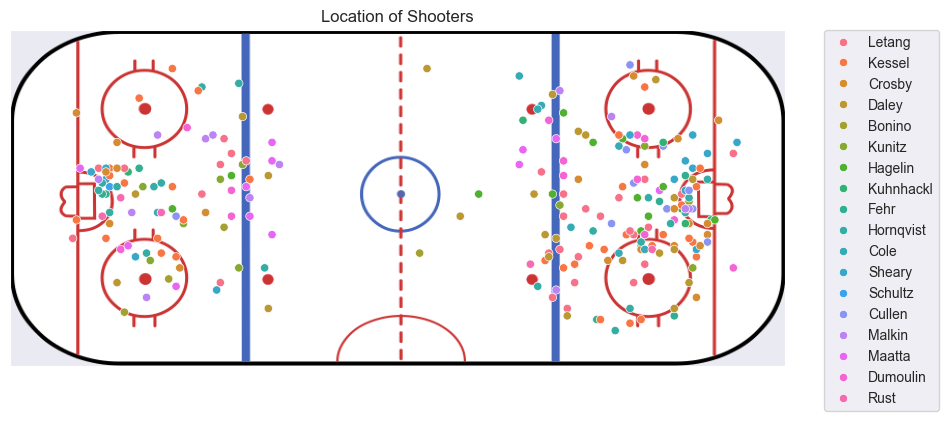

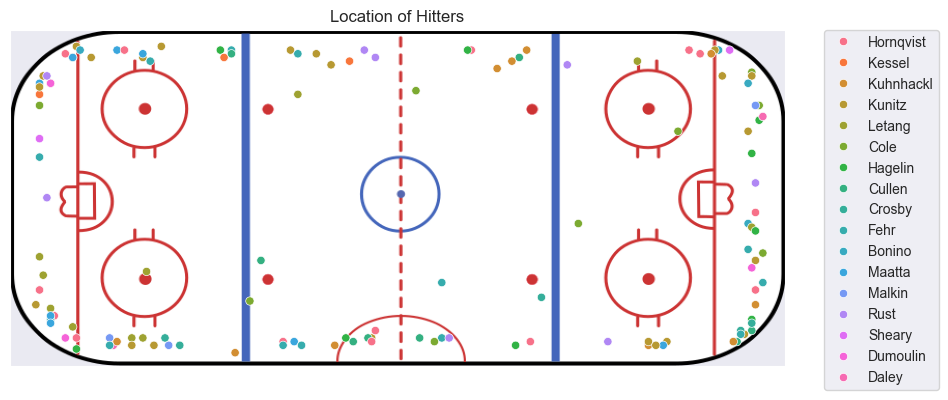

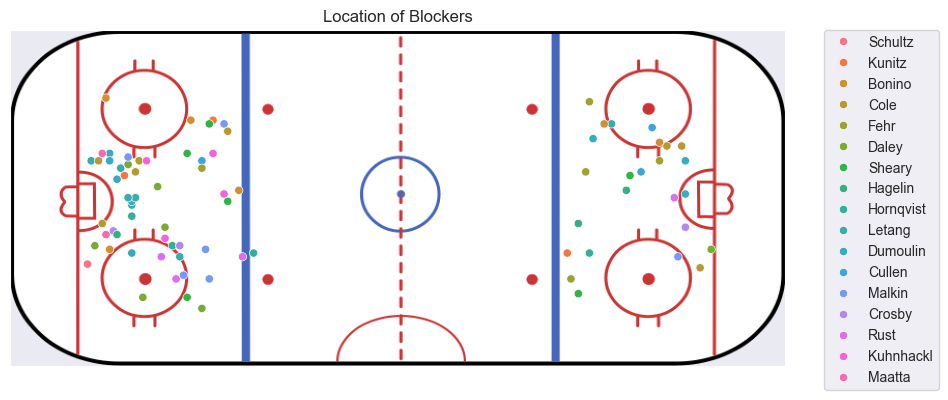

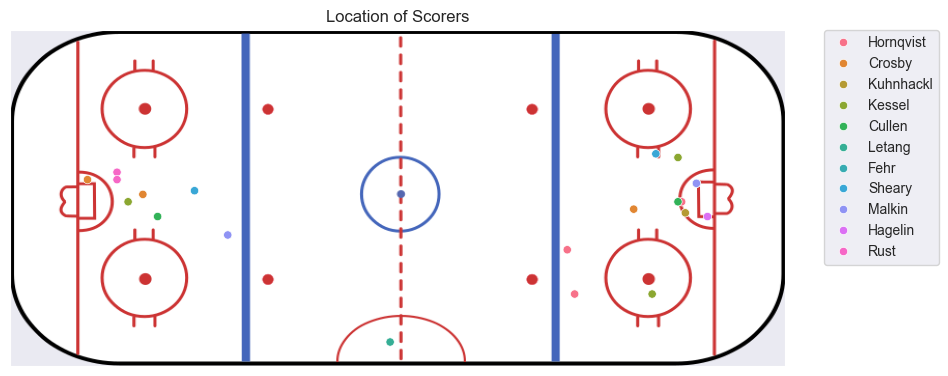

In [183]:
for type in good_player_types:
    plotHockeyPoints(Round_1_2016_good_plays, 'playerType', type)

In [186]:
Round_1_2016_bad_plays = Round_1_2016_bad_plays[Round_1_2016_bad_plays['lastName'].isin(Pens_2016_roster_list)]
bad_player_types = Round_1_2016_bad_plays.playerType.unique()
bad_player_types
#keep in mind that in this case, the Shooter is of a blocked shot.

array(['Hittee', 'Shooter', 'DrewBy'], dtype=object)

In [187]:
Round_1_2016_bad_plays

,play_id,game_id,team_for,team_against,event,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,playerType,firstName,lastName
5,2015030141_7,2015030141,NYR,PIT,Hit,-5.0,-40.0,1,REGULAR,15,1185.0,2016-04-14 01:11:17,0,0,Hittee,Patric,Hornqvist
6,2015030141_8,2015030141,NYR,PIT,Blocked Shot,39.0,7.0,1,REGULAR,25,1175.0,2016-04-14 01:11:17,0,0,Shooter,Kris,Letang
11,2015030141_10,2015030141,NYR,PIT,Hit,-96.0,31.0,1,REGULAR,102,1098.0,2016-04-14 01:12:35,0,0,Hittee,Olli,Maatta
13,2015030141_11,2015030141,PIT,NYR,Shot,45.0,-19.0,1,REGULAR,115,1085.0,2016-04-14 01:12:47,0,0,Shooter,Phil,Kessel
16,2015030141_13,2015030141,PIT,NYR,Missed Shot,75.0,-13.0,1,REGULAR,133,1067.0,2016-04-14 01:13:06,0,0,Shooter,Sidney,Crosby
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2729,2015030145_362,2015030145,NYR,PIT,Hit,99.0,-5.0,3,REGULAR,973,227.0,2016-04-23 22:51:34,3,6,Hittee,Patric,Hornqvist
2730,2015030145_363,2015030145,NYR,PIT,Hit,82.0,-40.0,3,REGULAR,983,217.0,2016-04-23 22:51:45,3,6,Hittee,Patric,Hornqvist
2733,2015030145_364,2015030145,NYR,PIT,Hit,96.0,-31.0,3,REGULAR,1030,170.0,2016-04-23 22:52:31,3,6,Hittee,Tom,Kuhnhackl
2736,2015030145_367,2015030145,NYR,PIT,Hit,-89.0,-39.0,3,REGULAR,1062,138.0,2016-04-23 22:53:30,3,6,Hittee,Chris,Kunitz


Plot play locations for good and bad plays, Round 1, 2016 Playoffs:

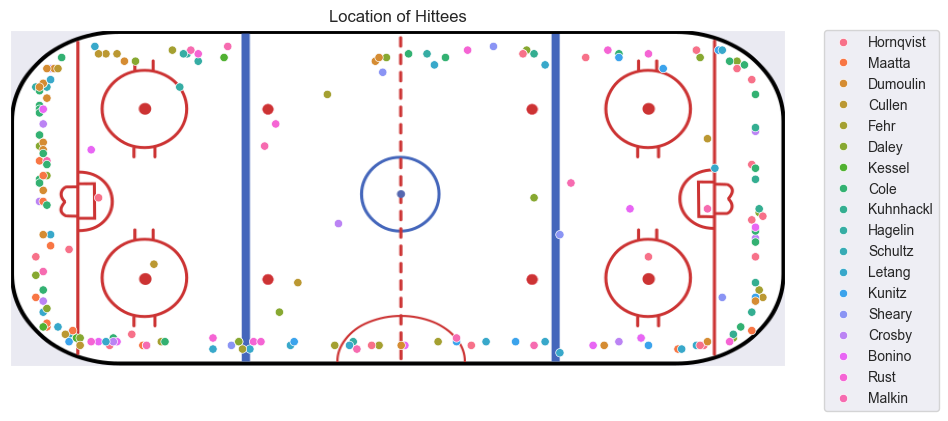

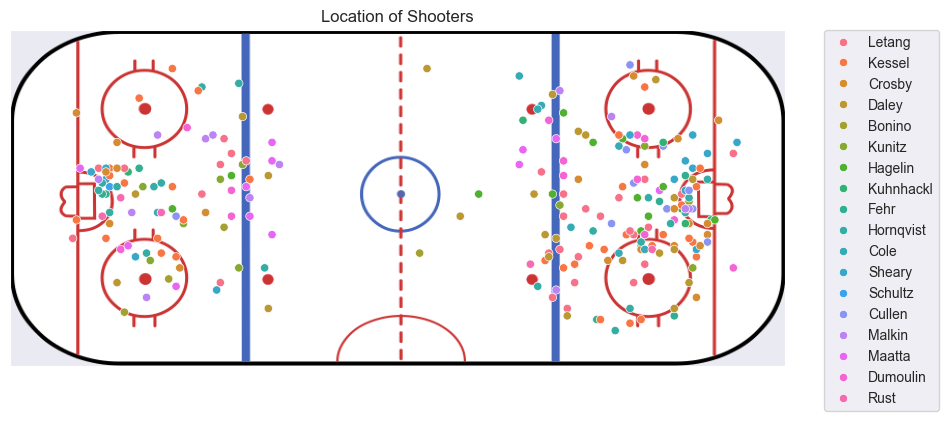

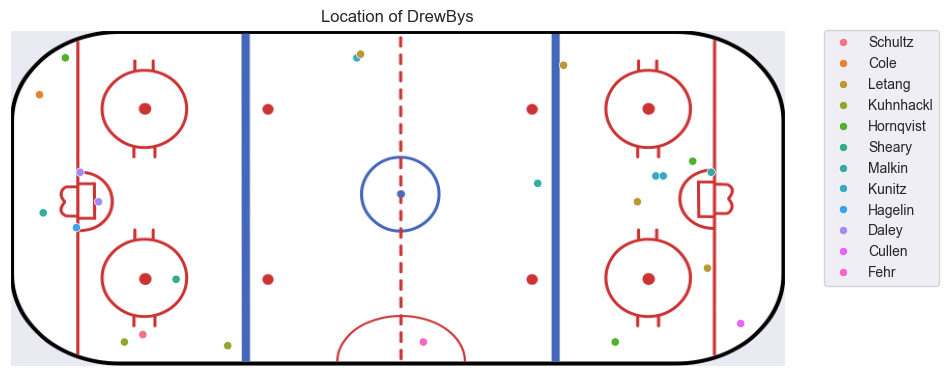

In [188]:
for type in bad_player_types:
    plotHockeyPoints(Round_1_2016_bad_plays, 'playerType', type)

### Next, begin gathering more skater stats:

The next SQL query will pull in player stats already compiled per game per player.

In [405]:
pens_2016_playoff_skater_stats_df = pd.read_sql_query(q.skater_stats_query,conn)

In [406]:
pens_2016_playoff_skater_stats_df.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,...,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,firstName,lastName,abbreviation
0,2015030141,8464989,5,952,0,0,0,2.0,0,0,...,0,0,1.0,-1,757,195,0,Matt,Cullen,PIT
1,2015030141,8467096,3,1194,1,0,1,0.0,0,0,...,0,0,1.0,0,961,0,233,Dan,Boyle,NYR
2,2015030141,8468575,3,640,0,0,0,0.0,0,0,...,0,0,0.0,0,534,99,7,Dominic,Moore,NYR
3,2015030141,8470041,3,1114,1,0,1,2.0,0,1,...,0,0,1.0,-2,679,256,179,Rick,Nash,NYR
4,2015030141,8470110,5,1480,1,0,4,0.0,0,0,...,0,0,1.0,1,1038,45,397,Trevor,Daley,PIT


As we've already added names and team abbreviations, we can drop a couple of columns:

In [353]:
pens_2016_playoff_skater_stats_df = pens_2016_playoff_skater_stats_df.drop(['player_id','team_id'], axis=1)

### Before separating into individual games and playoff rounds, it's helpful to take a look at the playoffs as a whole for the Pittsburgh Penguins:

In [354]:
players_2016_sums_df = pens_2016_playoff_skater_stats_df.groupby('lastName').aggregate({'goals':'sum', 'assists':'sum', 'plusMinus':'sum', 'hits':'sum', 'game_id':'count', 'timeOnIce':'mean', 'shots':'sum', 'takeaways':'sum','giveaways':'sum','blocked':'sum'}).reset_index()
#Below, I remove any players that have played fewer than 15 games, since their impact as a whole is so greatly reduced. I can still look at them later when we do a game by game analysis.
players_2016_sums_df = players_2016_sums_df[players_2016_sums_df['game_id']>15]
players_2016_sums_df


,lastName,goals,assists,plusMinus,hits,game_id,timeOnIce,shots,takeaways,giveaways,blocked
4,Bonino,4,14,9,16.0,24,1032.041667,41,12.0,9.0,50.0
17,Cole,1,2,6,49.0,24,972.750000,16,5.0,23.0,52.0
19,Crosby,6,13,-2,32.0,24,1226.333333,69,21.0,19.0,15.0
20,Cullen,4,2,3,25.0,24,829.791667,25,10.0,10.0,26.0
26,Dumoulin,2,6,-3,34.0,24,1291.458333,26,5.0,12.0,31.0
28,Fehr,3,1,-1,49.0,23,698.913043,35,7.0,4.0,15.0
33,Hagelin,6,10,9,41.0,24,982.958333,59,9.0,12.0,13.0
37,Hornqvist,9,4,-5,88.0,24,1042.500000,80,10.0,10.0,36.0
41,Kessel,10,12,5,9.0,24,1066.958333,98,10.0,14.0,4.0
47,Kuhnhackl,2,3,1,63.0,24,658.708333,15,5.0,1.0,15.0


In [429]:
print('TOP FIVE SCORERS')
players_2016_sums_df[['lastName','goals']].sort_values(by='goals', ascending=False).head(5)

TOP FIVE SCORERS


,lastName,goals
41,Kessel,10
37,Hornqvist,9
19,Crosby,6
77,Rust,6
54,Malkin,6


In [430]:
print('TOP FIVE IN ASSISTS')
players_2016_sums_df[['lastName','assists']].sort_values(by='assists', ascending=False).head()

TOP FIVE IN ASSISTS


,lastName,assists
4,Bonino,14
19,Crosby,13
50,Letang,12
54,Malkin,12
41,Kessel,12


In [431]:
print('TOP FIVE FOR +/-')
players_2016_sums_df[['lastName','plusMinus']].sort_values(by='plusMinus',ascending=False).head()

TOP FIVE FOR +/-


,lastName,plusMinus
4,Bonino,9
33,Hagelin,9
77,Rust,7
17,Cole,6
50,Letang,6


In [432]:
print('TOP FIVE FOR SHOTS MADE')
players_2016_sums_df.sort_values(by='shots', ascending=False).head()

TOP FIVE FOR SHOTS MADE


,lastName,goals,assists,plusMinus,hits,game_id,timeOnIce,shots,takeaways,giveaways,blocked,shots_made_percent
41,Kessel,10,12,5,9.0,24,1066.958333,98,10.0,14.0,4.0,10.204082
37,Hornqvist,9,4,-5,88.0,24,1042.500000,80,10.0,10.0,36.0,11.250000
54,Malkin,6,12,1,20.0,23,1050.521739,72,17.0,16.0,16.0,8.333333
50,Letang,3,12,6,53.0,23,1732.782609,70,14.0,30.0,38.0,4.285714
19,Crosby,6,13,-2,32.0,24,1226.333333,69,21.0,19.0,15.0,8.695652


In [356]:
#calculate percent of successful shots:
players_2016_sums_df['shots_made_percent'] = (players_2016_sums_df['goals']/players_2016_sums_df['shots'])*100

In [433]:
print('TOP FIVE FOR SHOT SUCCESS %')
players_2016_sums_df.sort_values(by='shots_made_percent',ascending=False).head()

TOP FIVE FOR SHOT SUCCESS %


,lastName,goals,assists,plusMinus,hits,game_id,timeOnIce,shots,takeaways,giveaways,blocked,shots_made_percent
77,Rust,6,3,7,34.0,23,690.739130,34,9.0,1.0,14.0,17.647059
20,Cullen,4,2,3,25.0,24,829.791667,25,10.0,10.0,26.0,16.000000
47,Kuhnhackl,2,3,1,63.0,24,658.708333,15,5.0,1.0,15.0,13.333333
37,Hornqvist,9,4,-5,88.0,24,1042.500000,80,10.0,10.0,36.0,11.250000
80,Sheary,4,6,-1,23.0,23,837.826087,38,13.0,8.0,13.0,10.526316


Text(0.5, 1.0, 'Total Goals vs. Time on Ice')

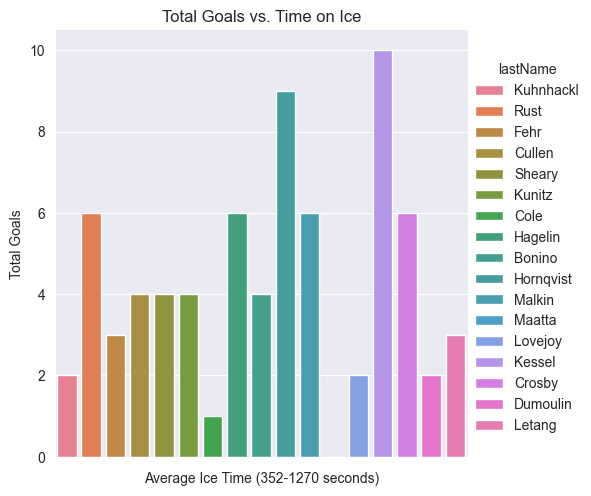

In [359]:
fig = sns.catplot(data= players_2016_sums_df, x='timeOnIce',y='goals',hue='lastName',kind='bar')
fig.set_axis_labels('Average Ice Time (352-1270 seconds)', 'Total Goals')
fig.set(xticklabels=[])
plt.title('Total Goals vs. Time on Ice')


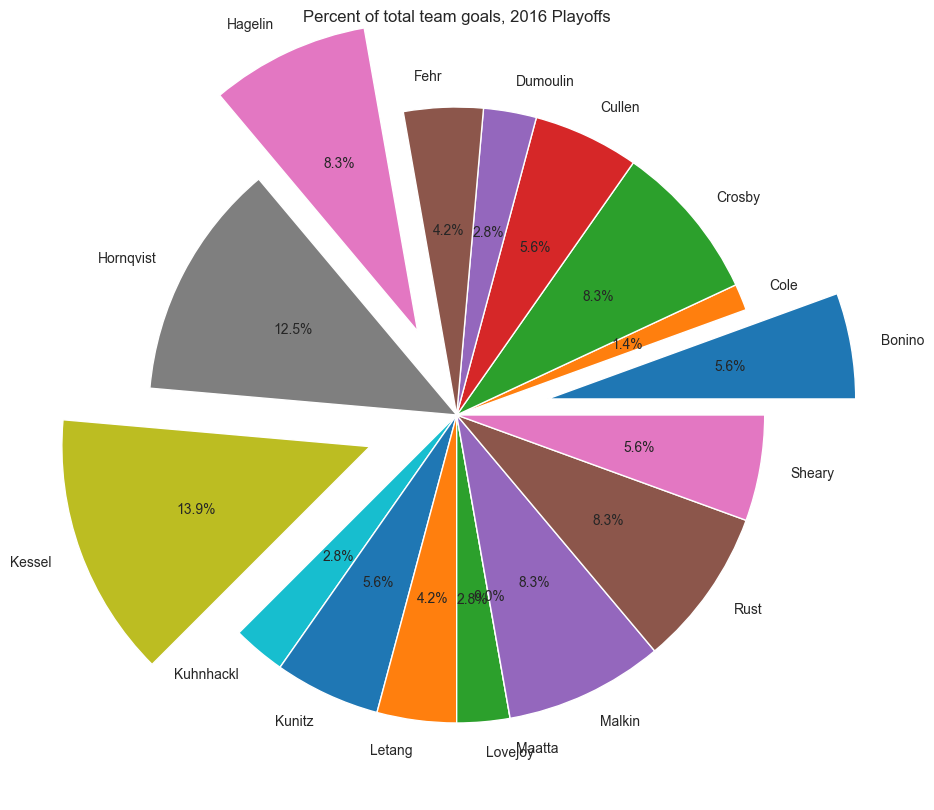

In [419]:
labels = players_2016_sums_df['lastName']
explode = [0.3,0,0,0,0,0,0.3,0,0.3,0,0,0,0,0,0,0,0]
sizes = players_2016_sums_df['goals']

plt.figure(0,figsize = (10,10))
plt.pie(sizes, labels=labels, explode = explode, autopct='%1.1f%%')
plt.title('Percent of total team goals, 2016 Playoffs')
plt.show()

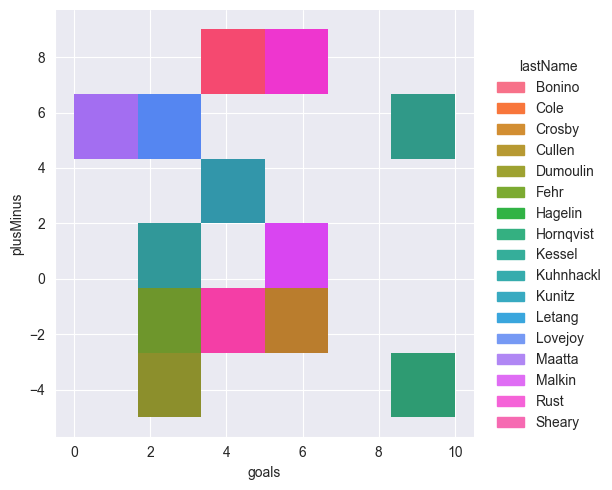

In [420]:
ax = sns.displot(data=players_2016_sums_df, y='plusMinus',x='goals', hue='lastName')
plt.show()

<Axes: xlabel='plusMinus', ylabel='Density'>

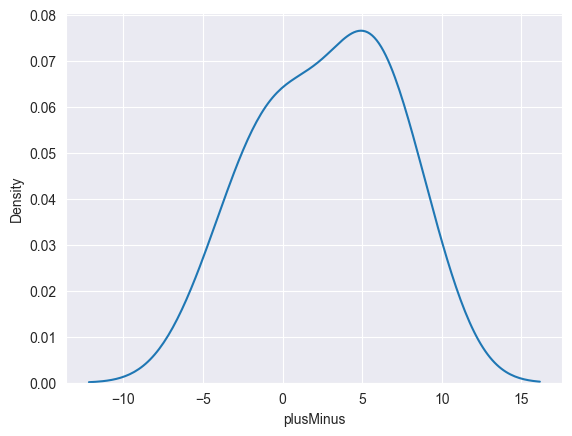

In [380]:
sns.kdeplot(data=players_2016_sums_df,x='plusMinus')